# Shape approximation of a spherical-cap bubble

## Outline

1. [Starting point](#starting_point)
2. [Volume-of-fluid data](#vof_data)
3. [Parameterization](#parameterization)
4. [Simple function approximation](#function_approximation)
5. [Direct approximation of the radius](#direct_approximation)
6. [Using prior/domain knowledge](#prior_knowledge)
    1. [Re-scaling the data](#rescaling)
    2. [Adding artificial data](#artificial_data)
7. [Final notes](#final_notes)

## Starting point<a id="starting_point"></a>



In [13]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import torch
import sys
IN_COLAB = 'google.colab' in sys.modules
matplotlib.rcParams['figure.dpi'] = 80

print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("PyTorch version: {}".format(torch.__version__))
print("Running notebook {}".format("in colab." if IN_COLAB else "locally."))

Pandas version: 0.24.2
Numpy version: 1.16.2
PyTorch version: 1.0.0
Running notebook locally.


## Volume-of-fluid data<a id="vof_data"></a>

In [14]:
if not IN_COLAB:
    data_file = "../data/bhaga_03_l16.csv"
else:
    data_file = "https://raw.githubusercontent.com/AndreWeiner/machine-learning-applied-to-cfd/master/data/bhaga_03_l16.csv"
data = pd.read_csv(data_file, header=0)
print("The data set contains {} points.".format(data.shape[0]))
data.head()

The data set contains 1170 points.


,px,py
0,-0.157689,0.596598
1,-0.157689,0.596924
2,-0.157689,0.596924
3,-0.158289,0.600586
4,-0.158289,0.600586


<IPython.core.display.Javascript object>


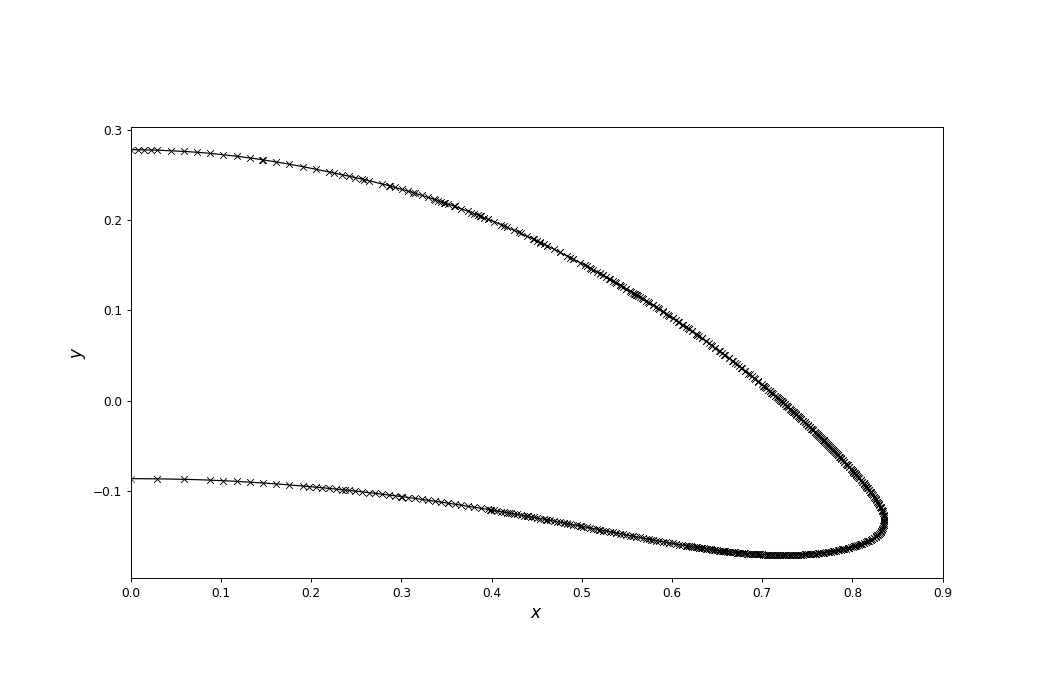

In [18]:
%matplotlib notebook

fontsize = 14

fig, ax = plt.subplots(figsize=(12, 8))

line_segments = [[(data.py[i], data.px[i]),(data.py[i+1], data.px[i+1])] for i in range(0, data.shape[0] - 1, 2) ]
lc = mc.LineCollection(line_segments, linewidths=1, colors='k')
ax.add_collection(lc)
ax.autoscale()

x = [i[0] for j in line_segments for i in j]
y = [i[1] for j in line_segments for i in j]
ax.scatter(x, y, marker='x', color='k', s=30, linewidth=0.5)

ax.set_aspect('equal')
ax.set_xlabel(r"$x$", fontsize=fontsize)
ax.set_ylabel(r"$y$", fontsize=fontsize)
ax.set_xlim(0.0, 0.9)
plt.show()

## Parameterization<a id="parameterization"></a>

In [19]:
def polar_coordinates(px, py):
    '''Converts raduis from Cartesian coordinates r(x,y) to polar coordinates r(phi)
    
    Parameters
    ----------
    px, py - array-like: x and y coordinates of PLIC points
    
    Returns
    -------
    radius - array-like: radii of PLIC points
    phi - array-like: polar angle
    
    '''
    radius = np.sqrt(np.square(px) + np.square(py))
    phi = np.arccos(py / radius)
    return radius, phi

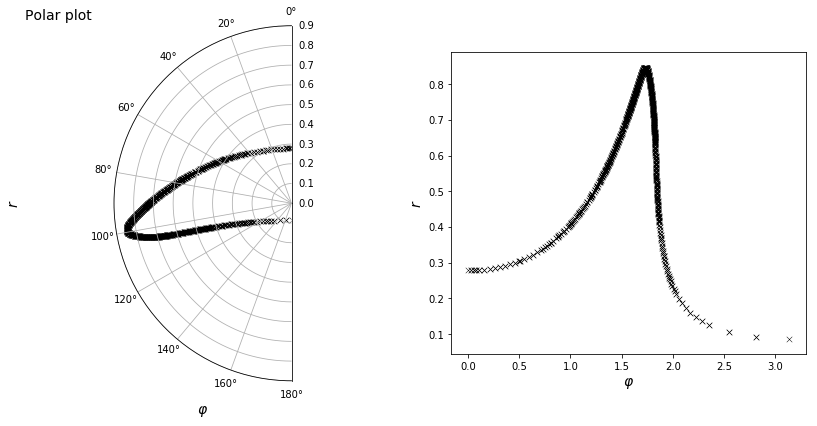

In [20]:
%matplotlib inline

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(121, projection='polar')
ax2 = plt.subplot(122)

radius, phi = polar_coordinates(data.py, data.px)

ax1.set_theta_zero_location("N")
ax1.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax1.set_xlim(0.0, np.pi)
ax1.set_title("Polar plot", loc='left', fontsize=fontsize)
ax1.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax1.set_ylabel(r"$r$", fontsize=fontsize)

ax2.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax2.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax2.set_ylabel(r"$r$", fontsize=fontsize)
asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
ax2.set_aspect(asp)
    
plt.show()

## Simple function approximation<a id="function_approximation"></a>

In [21]:
torch.set_default_tensor_type(torch.DoubleTensor)

class SimpleMLP(torch.nn.Module):
    def __init__(self, n_inputs=1, n_outputs=1, n_layers=1, n_neurons=10, activation=torch.sigmoid):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.activation = activation
        self.layers = torch.nn.ModuleList()
        # input layer to first hidden layer
        self.layers.append(torch.nn.Linear(self.n_inputs, self.n_neurons))
        # add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(torch.nn.Linear(self.n_neurons, self.n_neurons))
        # last hidden layer to output layer
        self.layers.append(torch.nn.Linear(self.n_neurons, self.n_outputs))
        
    def forward(self, x):
        for i_layer in range(self.n_layers):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

In [22]:
def approximate_function(x, y, model, l_rate=0.001, max_iter=1000, path=None):
    '''Train MLP to approximate a function y(x).
       The training stops when the maximum number of training epochs is reached.
    
    Parameters
    ----------
    x - array-like    : argument of the function
    y - array-like    : function value at x
    model - SimpleMLP : PyTorch model which is adjusted to approximate the function
    l_rate - Float    : learning rate for weight optimization
    max_iter - Integer: maximum number of allowed training epochs
    path - String     : location to save model weights
    
    Returns
    -------
    model - SimpleMLP: trained version of the given model
    
    '''
    # convert coordinates to torch tensors
    x_tensor = torch.from_numpy(x).unsqueeze_(-1)
    y_tensor = torch.from_numpy(y)
    # define loss function
    criterion = torch.nn.MSELoss()
    # define optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l_rate)
    
    # training loop
    best_loss = 1.0E5
    for e in range(1, max_iter+1):
        # backpropagation
        optimizer.zero_grad()
        output = model.forward(x_tensor)
        loss = criterion(output.squeeze(dim=1), y_tensor)
        loss.backward()
        optimizer.step()
        # check error
        diff = output.squeeze(dim=1) - y_tensor
        max_diff = np.amax(np.absolute(diff.detach().numpy()))
        if loss.item() < best_loss:
            best_loss = loss.item()
            print("Loss/max. dev. decreased in epoch {}: {}/{}".format(e, loss.item(), max_diff))
            print("Saving model as {}".format(path))
            if path is not None:
                torch.save(model.state_dict(), path)
    return model.eval()

## Direkt approximation of the radius<a id="direct_approximation"></a>

In [23]:
radius_model_direct = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_direct = approximate_function(phi.values, radius.values, radius_model_direct, max_iter=1500,
                                           l_rate=0.01, path="models/radius_model_direct.pt")

Loss/max. dev. decreased in epoch 1: 0.14424635535585706/0.5553440835696268
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 2: 0.037061710874372836/0.6212060224099625
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 6: 0.03399922897779953/0.4839652925819513
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 11: 0.030814748273289515/0.5305841607300569
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 24: 0.03069718944628482/0.5418176541576908
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 61: 0.030696707535902267/0.5416809594131538
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 72: 0.030696582390884887/0.5410268158524835
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 83: 0.030696149661886916/0.5418055414008289
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 88: 0.030695798805500944/0.541561696

Loss/max. dev. decreased in epoch 170: 0.030077244134651546/0.5448694721267491
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 171: 0.029994198508528132/0.5452081524084004
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 172: 0.029899748001534648/0.5455844735417354
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 173: 0.029792494051559145/0.5460151399991097
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 174: 0.029670908200985426/0.5465111423293841
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 175: 0.029533340325774725/0.5470766416388821
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 176: 0.02937805359541852/0.5477134841453577
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 177: 0.029203263379850755/0.5484253457163993
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 178: 0.0290071803413715

Loss/max. dev. decreased in epoch 275: 0.021086165992117156/0.5886529203185706
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 276: 0.02108606948965136/0.5886368360750015
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 277: 0.02108594202385762/0.5886771296157822
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 278: 0.021085820266504143/0.588759887576019
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 279: 0.021085719494622946/0.5888391857967513
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 280: 0.021085622851283743/0.5888436650113452
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 281: 0.021085524871270887/0.5887683499066186
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 282: 0.02108544143028855/0.5886859551892749
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 283: 0.021085364306454427/

Loss/max. dev. decreased in epoch 376: 0.021080205881516788/0.5887492650051299
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 377: 0.02108015957930046/0.5887498384914022
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 378: 0.02108011249222361/0.5887498828390585
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 379: 0.021080064524130308/0.5887496756795867
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 380: 0.021080015568373696/0.5887494970210633
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 381: 0.02107996550465429/0.5887494632139398
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 382: 0.02107991419903712/0.5887497999609868
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 383: 0.021079861501901883/0.5887503646479877
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 384: 0.021079807244099767/

Loss/max. dev. decreased in epoch 449: 0.010580393284470373/0.4684818797776408
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 450: 0.00864255333053076/0.4302664343020409
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 451: 0.007379382325017397/0.41519044184444853
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 452: 0.007191314278034734/0.4133457869648436
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 454: 0.006277485602042478/0.3831824526847855
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 455: 0.0039436853214857345/0.3380000936652955
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 459: 0.0018275785409204168/0.26088284606709683
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 463: 0.0010060457390653418/0.19621396427463994
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 466: 0.0009231990

Loss/max. dev. decreased in epoch 599: 0.000187276247420629/0.1286307068231815
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 600: 0.0001865525181959353/0.12838808072919022
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 601: 0.00018583513160525162/0.1281273484167436
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 602: 0.00018512149935290807/0.12792763116552347
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 603: 0.00018440993667772796/0.12764160783126116
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 604: 0.0001837040639005184/0.12740621041683647
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 605: 0.00018300422010711234/0.12717401178422666
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 606: 0.00018230971717975037/0.1269072040180464
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 607: 

Loss/max. dev. decreased in epoch 668: 0.0001489806793932121/0.11282937638645894
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 669: 0.00014859990150062046/0.11261732311621526
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 670: 0.00014822389650065863/0.11241029683774549
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 671: 0.00014785264278664105/0.11219939414423206
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 672: 0.00014748612018145607/0.11199311336378133
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 673: 0.0001471243047869435/0.11178418524931362
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 674: 0.0001467671756563432/0.11157894387503921
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 675: 0.0001464147073753282/0.11137109955458431
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 67

Loss/max. dev. decreased in epoch 828: 0.00012901370271913349/0.09718394849759211
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 829: 0.0001289290147080513/0.09710774536454346
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 830: 0.00012885590535838428/0.09707366575097075
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 831: 0.00012878087769942193/0.09687208332339838
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 832: 0.0001286973247400446/0.09688136787026223
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 833: 0.0001286103512922719/0.09671760961889182
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 834: 0.00012852943409845106/0.09665383516934363
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 835: 0.0001284559777485459/0.09660581223054167
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 83

Loss/max. dev. decreased in epoch 897: 0.00012464940540870366/0.09205259891983437
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 898: 0.00012459950531292513/0.09199696853148563
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 899: 0.00012454984056714744/0.09193200737045466
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 900: 0.00012450040677532937/0.09187709340100188
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 901: 0.00012445120211039602/0.0918141333124871
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 902: 0.0001244022236374781/0.09175838336824223
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 903: 0.00012435346861960705/0.09169763932885704
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 904: 0.00012430493356965886/0.09164050955980514
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 

Loss/max. dev. decreased in epoch 1083: 0.00011970240968318806/0.08985270066641067
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1084: 0.00011966892261598729/0.08963577964348705
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1085: 0.00011962399444749258/0.08971212394991519
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1086: 0.00011956729104259296/0.08952252847689916
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1087: 0.00011951425558041913/0.08953137003215873
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1088: 0.00011947146756648433/0.08947235776652722
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1089: 0.0001194351094471364/0.0893207287422468
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1090: 0.00011939599770804516/0.08936339005295259
Saving model as radius_model_direct.pt
Loss/max. dev. decreased i

Loss/max. dev. decreased in epoch 1186: 0.00011578497599271295/0.08454664172799668
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1187: 0.00011574903237079732/0.08450726707067645
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1188: 0.0001157130721834367/0.08446808836831267
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1189: 0.00011567709481944387/0.08442919196861705
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1190: 0.00011564109968612291/0.08439009566756407
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1191: 0.00011560508612338256/0.08435143697064669
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1192: 0.00011556905369065898/0.08431238409582138
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1193: 0.00011553300172269133/0.08427414957747649
Saving model as radius_model_direct.pt
Loss/max. dev. decreased 

Loss/max. dev. decreased in epoch 1385: 0.00011095657678558476/0.08271717088642146
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1386: 0.00011091637910232632/0.08266105942785724
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1387: 0.00011087671587451245/0.08260706196789332
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1388: 0.00011083720782687993/0.08251955590704114
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1389: 0.00011079772558071913/0.08247891265299657
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1390: 0.00011075809260809614/0.08239471810824099
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1391: 0.00011071860768141641/0.08235083640502296
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1392: 0.00011067945922590321/0.08228558822077088
Saving model as radius_model_direct.pt
Loss/max. dev. decreased

Loss/max. dev. decreased in epoch 1487: 0.00010737525549337473/0.07756041674534729
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1488: 0.00010734322064638424/0.07751860281663066
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1489: 0.000107311230216528/0.07747820726829817
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1490: 0.00010727928427364451/0.0774364661069223
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1491: 0.00010724738262400602/0.07739650972581778
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1492: 0.00010721552539818254/0.0773546861176616
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1493: 0.00010718371239646968/0.07731526052551253
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1494: 0.00010715194385291192/0.07727327029959662
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in 

Maximum relative deviation: 89.02% at angle 3.14.


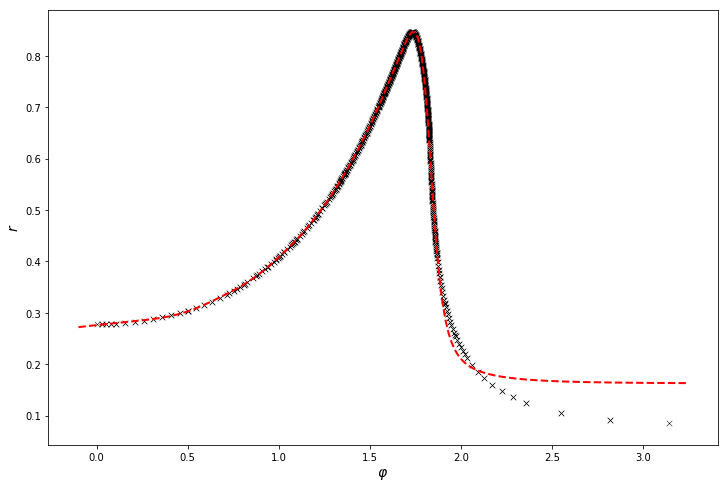

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))

eval_phi = np.linspace(-0.1, np.pi+0.1, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
# load best weights and compute forward pass
radius_model_direct.load_state_dict(torch.load("models/radius_model_direct.pt"))
model_radius = radius_model_direct.forward(phi_tensor).detach().squeeze().numpy()
phi_data_tensor = torch.from_numpy(phi.values).unsqueeze_(-1)
# evaluate maximum relative deviation
model_radius_data = radius_model_direct.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius.values)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius.values[diff_max_pos] * 100, phi.values[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.show()

## Using prior/domain knowledge<a id="prior_knowledge"></a>

### Re-scaling the data<a id="rescaling"></a>

The variance of the original radius is 0.0307.
The variance of the scaled radius is 0.0046.


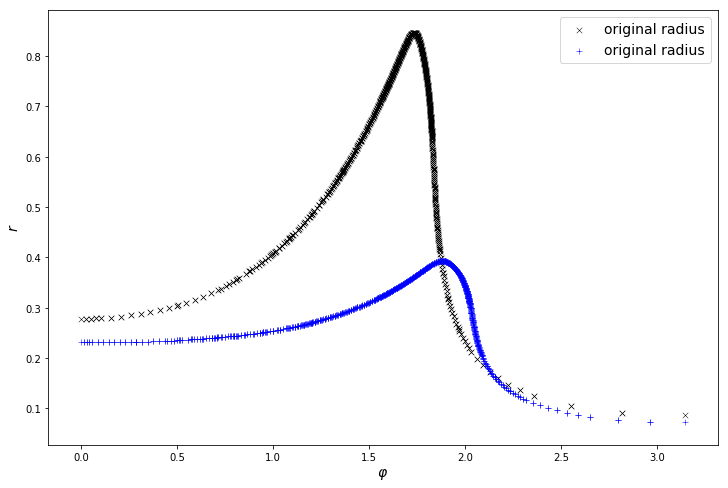

In [25]:
px_scaled = data.px.values * abs(np.amax(data.py.values) - np.amin(data.py.values))
py_scaled = data.py.values * abs(np.amax(data.px.values) - np.amin(data.px.values))

radius_scaled, phi_scaled = polar_coordinates(py_scaled, px_scaled)

print("The variance of the original radius is {:1.4f}.".format(np.var(radius.values)))
print("The variance of the scaled radius is {:1.4f}.".format(np.var(radius_scaled)))

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5, label=r"original radius")
ax.scatter(phi_scaled, radius_scaled, marker='+', color='b', s=30, linewidth=0.5, label=r"original radius")
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [26]:
radius_model_scaled = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_scaled = approximate_function(phi_scaled, radius_scaled, radius_model_scaled, max_iter=1500,
                                           l_rate=0.01, path="radius_model_scaled.pt")

Loss/max. dev. decreased in epoch 1: 0.31922754670405606/0.6524962910988845
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 2: 0.03214417525198382/0.25752310447502896
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 7: 0.021356016702077197/0.3586040478035919
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 8: 0.00465403979702877/0.23583276037602474
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 24: 0.004644357733297342/0.23506812781326003
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 41: 0.004635583974125489/0.22413364287494836
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 49: 0.00462815176722095/0.2335242699731977
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 56: 0.004615452146694351/0.23166086550913872
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 64: 0.00461191559564617/0.2308221

Loss/max. dev. decreased in epoch 195: 0.0045790681171645345/0.23015445664832657
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 196: 0.004577440247015943/0.23019396490775634
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 197: 0.004575709513859818/0.2302393155132445
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 198: 0.004573869125317277/0.2302881297593165
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 199: 0.004571911716102423/0.2303377885272731
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 200: 0.004569829329066941/0.23038633076304377
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 201: 0.004567613536116737/0.23043306535274438
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 202: 0.004565255515506188/0.23047872236841616
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 203: 0.004562745

Loss/max. dev. decreased in epoch 293: 0.003882647164324892/0.24464574702646175
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 294: 0.0038820929401709504/0.2446246692256832
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 295: 0.003881554593998909/0.24460320906024874
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 296: 0.0038810329747994725/0.24458159805391838
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 297: 0.0038805288020412033/0.2445602191557501
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 298: 0.0038800425273540153/0.244539541278747
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 299: 0.003879574204459004/0.24451999409042324
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 300: 0.003879123444652091/0.24450185915240136
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 301: 0.0038786

Loss/max. dev. decreased in epoch 395: 0.0038637946786755305/0.2445914238147615
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 396: 0.0038637387636914146/0.24459225013338898
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 397: 0.0038636836073381044/0.24459304972109902
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 398: 0.003863629192690244/0.2445938212851243
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 399: 0.0038635755031675646/0.24459456393970075
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 400: 0.003863522522488376/0.2445952771852143
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 401: 0.0038634702346218696/0.24459596079107299
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 402: 0.0038634186237389593/0.24459661482999545
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 403: 0.0038

Loss/max. dev. decreased in epoch 465: 0.003857581655824109/0.2443668706448175
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 466: 0.003856344138974418/0.2442748781601639
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 467: 0.0038545595699555598/0.2441399623895154
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 468: 0.0038520819156153464/0.24395153510521045
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 469: 0.0038489674827366024/0.24371676339906534
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 470: 0.003845605761991505/0.2434755521347215
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 471: 0.0038422905733067995/0.24328529111312952
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 472: 0.003838466538082998/0.2431685502275272
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 473: 0.00383321

Loss/max. dev. decreased in epoch 583: 1.774272754291182e-05/0.033629143908100845
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 584: 1.7438572944949962e-05/0.03341745846690662
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 585: 1.7433453740906315e-05/0.0332188498866334
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 586: 1.73966228886282e-05/0.03321105353246595
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 587: 1.7137897602733134e-05/0.03294327065658362
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 588: 1.6954291684018045e-05/0.03280941212108081
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 589: 1.6946178232053208e-05/0.03269802921526574
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 590: 1.6847689527628137e-05/0.03239580048503524
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 5

Loss/max. dev. decreased in epoch 652: 1.2224731608661027e-05/0.022132542186034526
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 653: 1.218402150040867e-05/0.02202901994393655
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 654: 1.2144074938399478e-05/0.021932469790836503
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 655: 1.2104966933268535e-05/0.021836956066988197
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 656: 1.2066566497880165e-05/0.02173763509035327
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 657: 1.202871462425869e-05/0.02164670602962021
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 658: 1.1991436820371679e-05/0.021549469118500753
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 659: 1.195482892678072e-05/0.021458057142480114
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in ep

Loss/max. dev. decreased in epoch 749: 1.0112175807513993e-05/0.01599957688304264
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 750: 1.0102219371876661e-05/0.015979901818913983
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 751: 1.009490652117558e-05/0.01590728263825736
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 752: 1.0092706657594258e-05/0.015907276252954794
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 772: 1.0034856775829043e-05/0.014551506150849075
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 776: 9.850856217184217e-06/0.014355895950626613
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 780: 9.828221039960129e-06/0.01430478873424014
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 784: 9.775810732634047e-06/0.014313032457987387
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epo

Loss/max. dev. decreased in epoch 889: 8.848827980664742e-06/0.011534189072760562
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 890: 8.841175045889725e-06/0.011509320196819009
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 891: 8.833588045868459e-06/0.0114864405359911
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 892: 8.82605341724882e-06/0.011465578599726106
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 893: 8.81853489044414e-06/0.011439839737215782
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 894: 8.811006901268783e-06/0.01142050291409849
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 895: 8.803472955583231e-06/0.011394837761163984
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 896: 8.795956507469143e-06/0.01137434287100167
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 897:

Loss/max. dev. decreased in epoch 983: 8.206339393143972e-06/0.009599651934376341
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 984: 8.200139950719753e-06/0.009581199851737568
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 985: 8.193951219628278e-06/0.009563499952725471
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 986: 8.18777320903296e-06/0.009544938043755002
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 987: 8.181606207655356e-06/0.009527627614626166
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 988: 8.175450536914856e-06/0.009508783985801544
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 989: 8.169307229395429e-06/0.009492099653276187
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 990: 8.16317778678174e-06/0.009472649980535375
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 

Loss/max. dev. decreased in epoch 1130: 7.46841892136315e-06/0.008027077507427233
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1131: 7.463605534555397e-06/0.008023955826321733
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1132: 7.4589247430826996e-06/0.008036778093889252
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1133: 7.454122376994694e-06/0.008014887595039627
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1134: 7.449189436727723e-06/0.008029293924244063
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1135: 7.4443217906873245e-06/0.008021688814293215
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1136: 7.439599627412547e-06/0.008013874125326531
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1137: 7.43489159190327e-06/0.008026064999941934
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased

Loss/max. dev. decreased in epoch 1211: 7.099566926257334e-06/0.00785191180159861
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1212: 7.0952228607924745e-06/0.007849187051694212
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1213: 7.090882633840493e-06/0.00784715895152388
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1214: 7.086546229528113e-06/0.007844452644494987
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1215: 7.082213644304161e-06/0.007842252214260659
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1216: 7.077884874245358e-06/0.007839801703890564
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1217: 7.07355989497108e-06/0.00783730504624916
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1218: 7.0692386672612705e-06/0.007835105060218839
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased i

Loss/max. dev. decreased in epoch 1303: 6.7141427664391655e-06/0.007622855589108857
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1304: 6.710100032856237e-06/0.007620288068401926
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1305: 6.706060381584267e-06/0.00761771211422832
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1306: 6.702023814324273e-06/0.007615140342576682
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1307: 6.697990332973227e-06/0.007612561989285421
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1308: 6.69395993943711e-06/0.007609986242949868
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1309: 6.68993263578452e-06/0.007607405250204896
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1310: 6.685908424106355e-06/0.007604825705262663
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased i

Loss/max. dev. decreased in epoch 1437: 6.259376095234883e-06/0.0071687012396061955
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1441: 6.245589142770323e-06/0.007170471139618606
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1445: 6.235620621016138e-06/0.007250923438231693
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1448: 6.230701993892783e-06/0.007107619521621089
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1449: 6.224274375381074e-06/0.007115046523492208
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1452: 6.210581755399993e-06/0.007228167268777536
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1456: 6.194645465372646e-06/0.0071449557957171395
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1460: 6.180541505875912e-06/0.007189600171552013
Saving model as radius_model_scaled.pt
Loss/max. dev. decreas

Maximum relative deviation: 4.39% at angle 2.15.


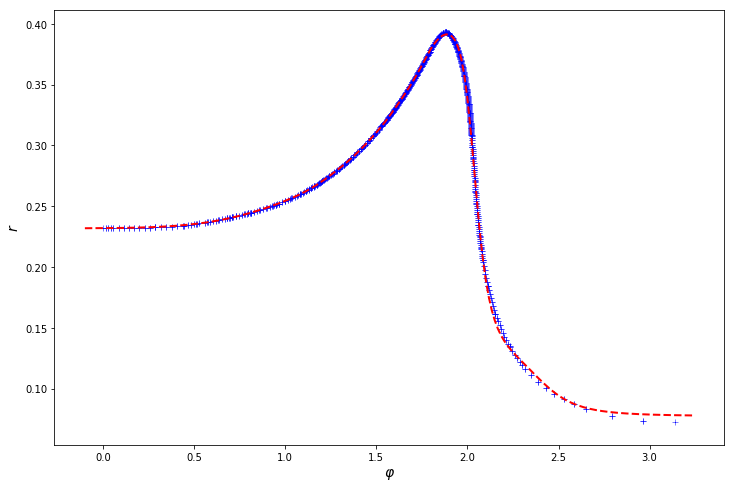

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))

# load best weights and compute forward pass
radius_model_scaled.load_state_dict(torch.load("radius_model_scaled.pt"))
model_radius = radius_model_scaled.forward(phi_tensor).detach().squeeze().numpy()
# evaluate maximum relative deviation
phi_data_tensor = torch.from_numpy(phi_scaled).unsqueeze_(-1)
model_radius_data = radius_model_scaled.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius_scaled)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius_scaled[diff_max_pos] * 100, phi_scaled[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi_scaled, radius_scaled, marker='+', color='b', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.show()

### Adding artificial data<a id="artificial_data"></a>

In [28]:
phi_threshold = 0.5
phi_add = []
radius_add = []

for p, r in zip(phi_scaled, radius_scaled):
    if p < phi_threshold:
        phi_add.append(-p)
        radius_add.append(r)
    if p > np.pi - phi_threshold:
        phi_add.append(2 * np.pi - p)
        radius_add.append(r)
        
phi_extended = np.concatenate((phi_scaled, np.asarray(phi_add)))
radius_extended = np.concatenate((radius_scaled, np.asarray(radius_add)))
print("Added {} points to the training data.".format(radius_extended.shape[0] - radius_scaled.shape[0]))

Added 52 points to the training data.


In [29]:
radius_model_extended = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_extended = approximate_function(phi_extended, radius_extended, radius_model_extended, max_iter=1500,
                                             l_rate=0.01, path="radius_model_extended.pt")

Loss/max. dev. decreased in epoch 1: 0.1182548584228594/0.43213687817219204
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 2: 0.006852068970395644/0.27001483540246896
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 6: 0.005548462438574747/0.19914419754460927
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 12: 0.0055155492174889555/0.2509949064445633
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 18: 0.0048617333461750244/0.22677737484177207
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 38: 0.0048604799919005435/0.22622181558430643
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 68: 0.004859771798211456/0.22567801291365497
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 90: 0.004859617655573013/0.2252275957769967
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 95: 0.0048

Loss/max. dev. decreased in epoch 201: 0.004852120354152981/0.22557425653208507
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 202: 0.004851701467209817/0.2255768629060091
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 203: 0.004851253801734913/0.22558311619753563
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 204: 0.004850774919085401/0.22559379540262614
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 205: 0.004850262233563271/0.22560759830284616
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 206: 0.004849712892254832/0.22562202129767062
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 207: 0.004849123670776924/0.22563478564071854
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 208: 0.004848491008822613/0.22564502551308696
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch

Loss/max. dev. decreased in epoch 279: 0.004049814227423655/0.24370720945031843
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 280: 0.004047455042333569/0.2435825880079931
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 281: 0.00404515959984528/0.2434155962869325
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 282: 0.004042944138614417/0.2432217807963698
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 283: 0.004040818807364718/0.24302544710628426
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 284: 0.004038843707390692/0.2428527352004472
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 285: 0.0040371129281023465/0.24272150593588526
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 286: 0.004035712329298788/0.24263304183381695
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 28

Loss/max. dev. decreased in epoch 378: 0.004022662346610262/0.24264160117761624
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 379: 0.00402261749343475/0.24264187096323986
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 380: 0.004022572535456883/0.2426422154944034
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 381: 0.004022527440915097/0.24264258885692797
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 382: 0.004022482179217434/0.2426428248102428
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 383: 0.0040224367174702454/0.2426427654086391
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 384: 0.0040223910186607675/0.24264238063702104
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 385: 0.0040223450414717124/0.24264180216128056
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch

Loss/max. dev. decreased in epoch 446: 0.0040064265190636215/0.24234846927449127
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 447: 0.004004249637771015/0.2422998414964398
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 448: 0.004001502333493318/0.24223925533022622
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 449: 0.003997940590342818/0.24216165343986912
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 450: 0.0039931950315295036/0.2420587390675934
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 451: 0.003986745529321374/0.2419164750689446
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 452: 0.0039780072739331/0.24171084342691307
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 453: 0.0039667364602885506/0.24140174177320317
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 

Loss/max. dev. decreased in epoch 591: 8.071456495913447e-06/0.019399437115371843
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 592: 7.941579941019899e-06/0.019270574107784114
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 593: 7.83283205134624e-06/0.019201941795356767
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 594: 7.70065085393153e-06/0.018952927253366142
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 595: 7.59325022086796e-06/0.018749813724969755
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 596: 7.482965257423938e-06/0.01866438545694979
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 597: 7.365897097515807e-06/0.01845932282535115
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 598: 7.269469578293606e-06/0.018233223893151254
Saving model as radius_model_extended.pt
Loss/max. dev. decrea

Loss/max. dev. decreased in epoch 692: 3.171980157742066e-06/0.00833822951625561
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 693: 3.1565995173162845e-06/0.008283965264163876
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 694: 3.141504522864056e-06/0.00823044285483418
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 695: 3.12668894935981e-06/0.008178261205280549
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 696: 3.11214669319538e-06/0.008125886371207675
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 697: 3.097872630866756e-06/0.008074845995766272
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 698: 3.0838613505879205e-06/0.008024725307968411
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 699: 3.0701067744392144e-06/0.00797440874979262
Saving model as radius_model_extended.pt
Loss/max. dev. dec

Loss/max. dev. decreased in epoch 784: 2.4330243638850446e-06/0.008321380752047886
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 785: 2.428728986028516e-06/0.00833707005933293
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 786: 2.4244673761796655e-06/0.00835246241341818
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 787: 2.4202388479559005e-06/0.008367565885123038
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 788: 2.4160427338113273e-06/0.008382370464002156
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 789: 2.4118783861458937e-06/0.008396897321214944
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 790: 2.4077451745889365e-06/0.00841113528093744
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 791: 2.4036424872842086e-06/0.008425096946307775
Saving model as radius_model_extended.pt
Loss/max. de

Loss/max. dev. decreased in epoch 878: 2.1223423042714657e-06/0.008927209003075809
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 879: 2.1196985978940146e-06/0.008927866574221052
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 880: 2.1170644659679937e-06/0.008928458960255722
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 881: 2.1144398276070026e-06/0.008928987373253927
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 882: 2.1118246031547206e-06/0.008929452886451597
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 883: 2.1092187141624753e-06/0.008929856803555292
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 884: 2.106622083357066e-06/0.008930200076408393
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 885: 2.1040346346230086e-06/0.008930484011899484
Saving model as radius_model_extended.pt
Loss/max.

Loss/max. dev. decreased in epoch 948: 1.956845242811013e-06/0.008864592842802263
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 949: 1.9547360847596248e-06/0.008866254164307114
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 950: 1.9526475704266223e-06/0.008859117386105161
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 951: 1.9505984921533037e-06/0.00886500624570273
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 952: 1.948631224228816e-06/0.0088514356023051
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 953: 1.9468438955186813e-06/0.008866955431598184
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 954: 1.9454627015420663e-06/0.008838721177270303
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 955: 1.9450157704516823e-06/0.008876458000694837
Saving model as radius_model_extended.pt
Loss/max. dev

Loss/max. dev. decreased in epoch 1135: 1.74631031097151e-06/0.00836658069351058
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1136: 1.744686127354003e-06/0.008370925232847895
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1137: 1.7430717530993536e-06/0.008371066978615602
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1138: 1.7414613476397983e-06/0.008377390805115986
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1139: 1.7398536283017826e-06/0.008377279034564422
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1140: 1.7382534775493553e-06/0.008382201115491233
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1141: 1.7366645235194453e-06/0.008384406282167425
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1142: 1.735087067631426e-06/0.008385893431313282
Saving model as radius_model_extended.pt
Loss/

Loss/max. dev. decreased in epoch 1230: 1.614010779645354e-06/0.008434715278377136
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1231: 1.6127497420345817e-06/0.008434189599604486
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1232: 1.6114899774910357e-06/0.008433584763762117
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1233: 1.6102314600521123e-06/0.008433046414849973
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1234: 1.6089741643002188e-06/0.008432413360796448
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1235: 1.6077180658115339e-06/0.008431860769663
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1236: 1.6064631406814424e-06/0.0084311972240953
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1237: 1.6052093659887173e-06/0.008430630585331639
Saving model as radius_model_extended.pt
Loss/m

Loss/max. dev. decreased in epoch 1426: 1.491790799556163e-06/0.008062317533800725
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1427: 1.4902452985514908e-06/0.008069610638429536
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1428: 1.488901632170122e-06/0.008062968350161334
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1429: 1.4875433915410706e-06/0.008088580999828052
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1430: 1.486082415668671e-06/0.008067762042635221
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1431: 1.48448008767643e-06/0.008097223081929145
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1432: 1.4828271689370458e-06/0.008085325149985154
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1433: 1.4812318362919206e-06/0.008102281823106475
Saving model as radius_model_extended.pt
Loss/

Loss/max. dev. decreased in epoch 1493: 1.4068783531611393e-06/0.008248186713856243
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1494: 1.4057794064724684e-06/0.008247283733198149
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1495: 1.4046832749957168e-06/0.008249837666776644
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1496: 1.4035899879746636e-06/0.0082487380044996
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1497: 1.4024994704884614e-06/0.00825130210309577
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1498: 1.401411736875605e-06/0.00825017963004826
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1499: 1.4003267342325956e-06/0.00825269560658598
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1500: 1.3992444609249157e-06/0.008251388321306813
Saving model as radius_model_extended.pt


Maximum relative deviation: 6.62% at angle 2.96.


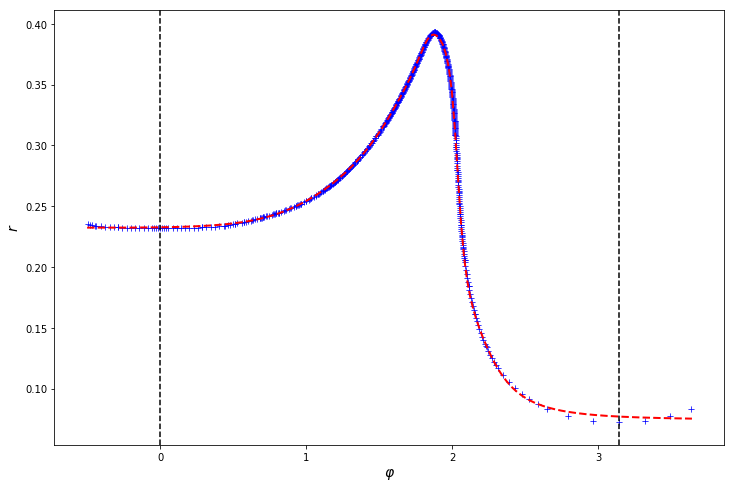

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

# load best weights and compute forward pass
eval_phi = np.linspace(-0.5, np.pi+0.5, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
radius_model_extended.load_state_dict(torch.load("radius_model_extended.pt"))
model_radius = radius_model_extended.forward(phi_tensor).detach().squeeze().numpy()
# evaluate maximum relative deviation (only in 0...pi)
phi_data_tensor = torch.from_numpy(phi_scaled).unsqueeze_(-1)
model_radius_data = radius_model_extended.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius_scaled)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius_scaled[diff_max_pos] * 100, phi_scaled[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi_extended, radius_extended, marker='+', color='b', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
ax.axvline(0.0, 0.0, 1.0, color='k', linestyle='--')
ax.axvline(np.pi, 0.0, 1.0, color='k', linestyle='--')
plt.show()

## Final notes<a id="final_notes"></a>

- play around with the number of layers and neurons per layer
- many layers, sigmoid suffers from vanishing gradient, change activation function, e.g., to *torch.relu*
- create a custom loss funtion that weights each individual inversly to the distribution of the training data over the polar angle.